In [1]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

                            
dataset = pd.read_csv('preprocessed_dataset_kathmandu.csv',index_col=0)                            

In [2]:
dataset.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 04:00:00,0.197154,0.161017,0.394737,0.916364,0.252308,0.0


In [69]:
# # Data cleaning
# dataset.drop('No', axis=1, inplace=True)
# dataset.columns = col_names
# dataset['pollution'].fillna(0, inplace=True)
# dataset = dataset[24:] # drop the first day
# print(dataset.head(5))
# dataset.to_csv('pollution.csv') # save new CSV

In [3]:
# load dataset
df = pd.read_csv('preprocessed_dataset_kathmandu.csv', header=0, index_col=0)
df.describe()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
count,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000
mean,0.045832,0.245428,0.561692,0.524710,0.673810,0.012659
std,0.045836,0.179375,0.209576,0.207259,0.189957,0.047958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018293,0.101695,0.413534,0.356364,0.504615,0.000000
50%,0.036585,0.211864,0.601504,0.552727,0.701538,0.000000
75%,0.060976,0.355932,0.714286,0.694545,0.852308,0.003300
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
dataset_columns = df.columns.tolist()
dataset_columns

['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

<Axes: >

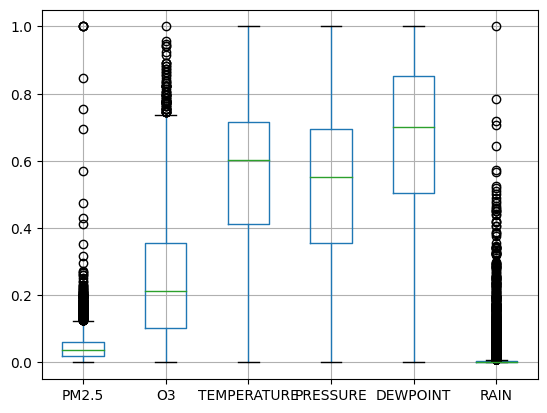

In [99]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [5]:
df

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 04:00:00,0.197154,0.161017,0.394737,0.916364,0.252308,0.0
...,...,...,...,...,...,...
2019-12-31 19:00:00,0.172764,0.042373,0.199248,0.847273,0.236923,0.0
2019-12-31 20:00:00,0.162602,0.033898,0.180451,0.850909,0.233846,0.0
2019-12-31 21:00:00,0.121951,0.016949,0.157895,0.854545,0.230769,0.0


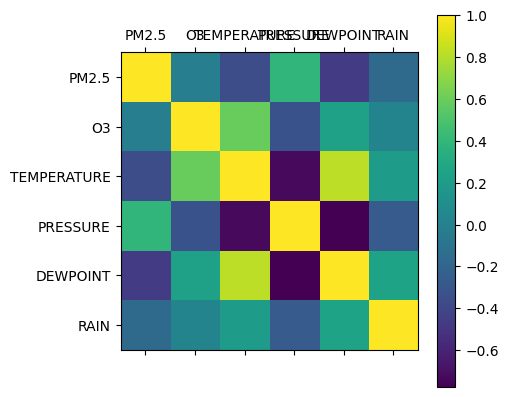

In [6]:
#Analysing relationship between different features
cor_cols = dataset_columns
plt.matshow(df.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [102]:
# from sklearn.preprocessing import LabelEncoder

# # Encode non categorical values
# values = df.values
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# values = values.astype('float32')
# values[:,4]

In [7]:
import numpy as np

mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm

threshold = 3
df = df[np.abs(z_scores) < threshold]

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[:,4]

array([28., 28., 35., ..., 24., 26., 31.], dtype=float32)

In [9]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [10]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [11]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (7562, 1)
X (7562, 4, 6)


In [12]:
# #Splitting the dataset
# n_train = 24*365
# X_train, X_test = X[n_train:,] , X[:n_train,]
# print('X_train' ,X_train.shape)
# print('X_test' ,X_test.shape)

# Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
# print('Y_train' ,Y_train.shape)
# print('Y_test' ,Y_test.shape)

In [13]:
from sklearn.model_selection import train_test_split


# Step 1: First, split into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Check the shapes of the splits
print("X_train shape after first split:", X_train.shape)
print("X_test shape after first split:", X_test.shape)

# Step 2: Split the training data further into training and validation sets
# 80% of the training data for training and 20% of it for validation
n_val = int(X_train.shape[0] * 0.2)  # 20% for validation from the training data

# Manually create validation and training data by slicing the X_train and y_train
X_val, X_train = X_train[:n_val], X_train[n_val:]
y_val, y_train = y_train[:n_val], y_train[n_val:]

# Check the shapes of the final splits
print("X_train shape after final split:", X_train.shape)
print("X_val shape after final split:", X_val.shape)
print("X_test shape after final split:", X_test.shape)

print("y_train shape after final split:", y_train.shape)
print("y_val shape after final split:", y_val.shape)
print("y_test shape after final split:", y_test.shape)


X_train shape after first split: (6049, 4, 6)
X_test shape after first split: (1513, 4, 6)
X_train shape after final split: (4840, 4, 6)
X_val shape after final split: (1209, 4, 6)
X_test shape after final split: (1513, 4, 6)
y_train shape after final split: (4840, 1)
y_val shape after final split: (1209, 1)
y_test shape after final split: (1513, 1)


In [14]:
# # Define training size and validation size
# n_train = 24 * 365   # For example, 1 year of data for training
# n_val = int(n_train * 0.2)  # Use 20% of the training data for validation (you can adjust the ratio)

# # Split the data
# X_train, X_test = X[n_train:,], X[:n_train,]
# Y_train, Y_test = Y[n_train:,], Y[:n_train,]

# # Further split the training data into training and validation sets
# X_val, X_train = X_train[:n_val,], X_train[n_val:,]
# Y_val, Y_train = Y_train[:n_val,], Y_train[n_val:,]

# # Print the shapes to verify
# print('X_train', X_train.shape)
# print('X_test', X_test.shape)
# print('X_val', X_val.shape)

# print('Y_train', Y_train.shape)
# print('Y_test', Y_test.shape)
# print('Y_val', Y_val.shape)


In [15]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import keras_tuner as kt
import numpy as np

# Ensure n_steps and n_features are defined
n_steps = X_train.shape[1]  # Define number of time steps
n_features = 6  # Example feature count (update accordingly)

# Define hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    # Single LSTM layer with tuning of units
    model.add(LSTM(
        units=hp.Choice('units', [8, 16, 32, 64, 128]),  # Tuning hidden units
        activation='relu',
        input_shape=(n_steps, n_features)
    ))
    
    # Dropout layer with tuning of dropout rate
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))  # Tuning dropout rate
    
    # Output layer
    model.add(Dense(1))  # Regression output
    
    # Optimizer Selection with different learning rates
    optimizer_choice = hp.Choice('optimizer', ['SGD', 'Adam', 'RMSprop'])  # Tuning optimizer
    
    if optimizer_choice == 'SGD':
        optimizer = SGD(
            learning_rate=hp.Choice('sgd_lr', [0.01, 0.005, 0.001, 0.0005]),  # Tuning SGD learning rate
            momentum=0.9, nesterov=True
        )
    elif optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate=hp.Choice('adam_lr', [0.001, 0.0005, 0.0001, 0.00005])  # Tuning Adam learning rate
        )
    else:  # RMSprop
        optimizer = RMSprop(
            learning_rate=hp.Choice('rmsprop_lr', [0.001, 0.0005, 0.0001, 0.00005]),  # Tuning RMSprop learning rate
            rho=0.9
        )
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='loss',  # Tuning for minimum loss
    max_trials=10,  # Number of trials for hyperparameter search
    executions_per_trial=1,  # Number of times each trial is executed
    directory='kt_tuning',  # Directory for storing tuning results
    project_name='lstm_aqi_tuning_v2'  # Project name for storing results
)

# Perform Hyperparameter Search (ensure you have validation data like X_split_val, y_split_val)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters
print(f"""
Best LSTM units: {best_hps.get('units')}
Best Dropout Rate: {best_hps.get('dropout')}
Best Optimizer: {best_hps.get('optimizer')}
Best Learning Rate: {best_hps.get('sgd_lr' if best_hps.get('optimizer') == 'SGD' else 'adam_lr' if best_hps.get('optimizer') == 'Adam' else 'rmsprop_lr')}
""")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Reloading Tuner from kt_tuning\lstm_aqi_tuning_v2\tuner0.json

Best LSTM units: 128
Best Dropout Rate: 0.2
Best Optimizer: Adam
Best Learning Rate: 0.0005

Epoch 1/50
152/152 [==============================] - 2s 6ms/step - loss: 0.0136 - mae: 0.0785 - val_loss: 0.0316 - val_mae: 0.1332
Epoch 2/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0067 - mae: 0.0532 - val_loss: 0.0286 - val_mae: 0.1276
Epoch 3/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0058 - mae: 0.0500 - val_loss: 0.0250 - val_mae: 0.1159
Epoch 4/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0052 - mae: 0.0468 - val_loss: 0.0214 - val_mae: 0.1098
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0047 - mae: 0.0452 - val_loss: 0.0187 - val_mae: 0.1004
Epoch 6/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0045 - mae: 0.0434 - val_loss: 0.0175 - val_mae: 0.0958
Epoch 7/50
152/152 [==============================] 

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Perform Predictions
y_pred = best_model.predict(X_test)

# Compute MSE, MAE, RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

48/48 [==============================] - 0s 1ms/step
RMSE: 0.08244247734546661
MSE: 0.0067967623472213745
MAE: 0.0588599368929863
R²: 0.6946079789693267


In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse, cv_mae, cv_rmse = [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train model on fold
    fold_model = tuner.hypermodel.build(best_hps)
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Predict
    y_val_pred = fold_model.predict(X_val_fold)

    # Compute Metrics
    fold_mse = mean_squared_error(y_val_fold, y_val_pred)
    fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    fold_rmse = np.sqrt(fold_mse)

    cv_mse.append(fold_mse)
    cv_mae.append(fold_mae)
    cv_rmse.append(fold_rmse)

# Print Cross Validation Results
# print(f"Cross-Validation MSE: {np.mean(cv_mse)} ± {np.std(cv_mse)}")
# print(f"Cross-Validation MAE: {np.mean(cv_mae)} ± {np.std(cv_mae)}")
# print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} ± {np.std(cv_rmse)}")

print(f"Cross-Validation MSE: {np.mean(cv_mse)} (std: {np.std(cv_mse)})")
print(f"Cross-Validation MAE: {np.mean(cv_mae)} (std: {np.std(cv_mae)})")
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} (std: {np.std(cv_rmse)})")


31/31 [==============================] - 0s 2ms/step
Cross-Validation MSE: 0.003220051061362028 (std: 0.0002959621197078377)
Cross-Validation MAE: 0.034914176911115646 (std: 0.0007705618627369404)
Cross-Validation RMSE: 0.05668846517801285 (std: 0.002543378621339798)


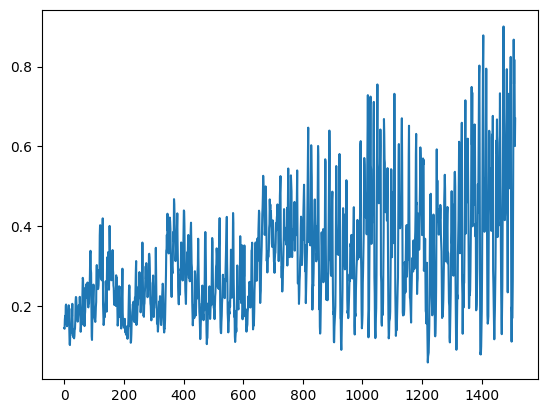

In [20]:
plt.plot(y_pred)

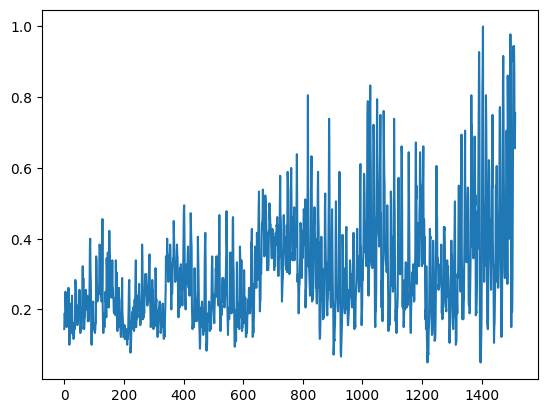

In [21]:
plt.plot(y_test)

In [22]:
_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.03295, Test: 0.05886


In [116]:
# #Taking predictions
# from keras.models import load_model
# model.save('AirPollutionMultivariate.h5')

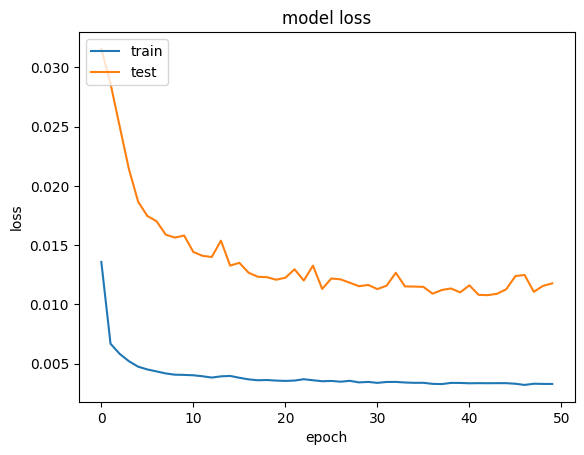

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch-wise validation loss:
Epoch 1: 0.03156629949808121
Epoch 2: 0.028641806915402412
Epoch 3: 0.025008201599121094
Epoch 4: 0.021420881152153015
Epoch 5: 0.01867492124438286
Epoch 6: 0.017469538375735283
Epoch 7: 0.017023811116814613
Epoch 8: 0.015888972207903862
Epoch 9: 0.015643281862139702
Epoch 10: 0.01581616885960102
Epoch 11: 0.014429953880608082
Epoch 12: 0.014104505069553852
Epoch 13: 0.014005427248775959
Epoch 14: 0.015382830984890461
Epoch 15: 0.013275873847305775
Epoch 16: 0.013515046797692776
Epoch 17: 0.012681939639151096
Epoch 18: 0.012337490916252136
Epoch 19: 0.012302417308092117
Epoch 20: 0.012087058275938034
Epoch 21: 0.012254645116627216
Epoch 22: 0.012966266833245754
Epoch 23: 0.012023111805319786
Epoch 24: 0.013274501077830791
Epoch 25: 0.011308382265269756
Epoch 26: 0.012193787842988968
Epoch 27: 0.01211791206151247
Epoch 28: 0.011832925491034985
Epoch 29: 0.011539365164935589
Epoch 30: 0.011645629070699215
Epoch 31: 0.0112979207187891
Epoch 32: 0.01158202439546

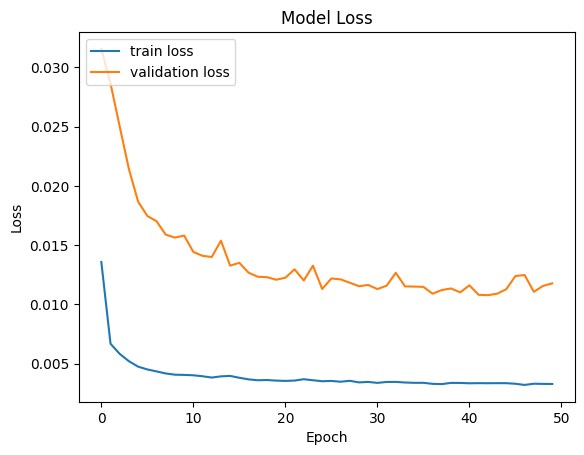

In [24]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

# Plotting the loss graph
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

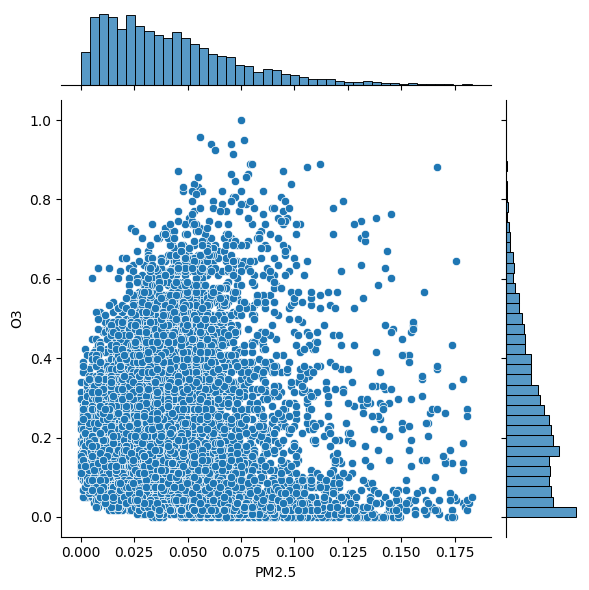

In [25]:
import seaborn as sns
sns.jointplot(x=df['PM2.5'], y=df['O3'], data = df)

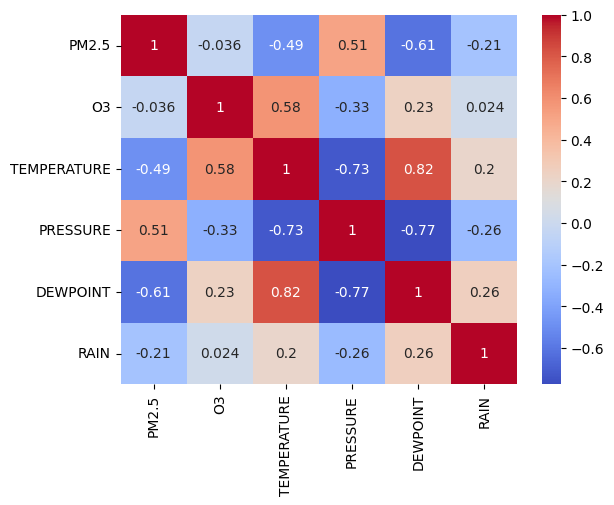

In [26]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

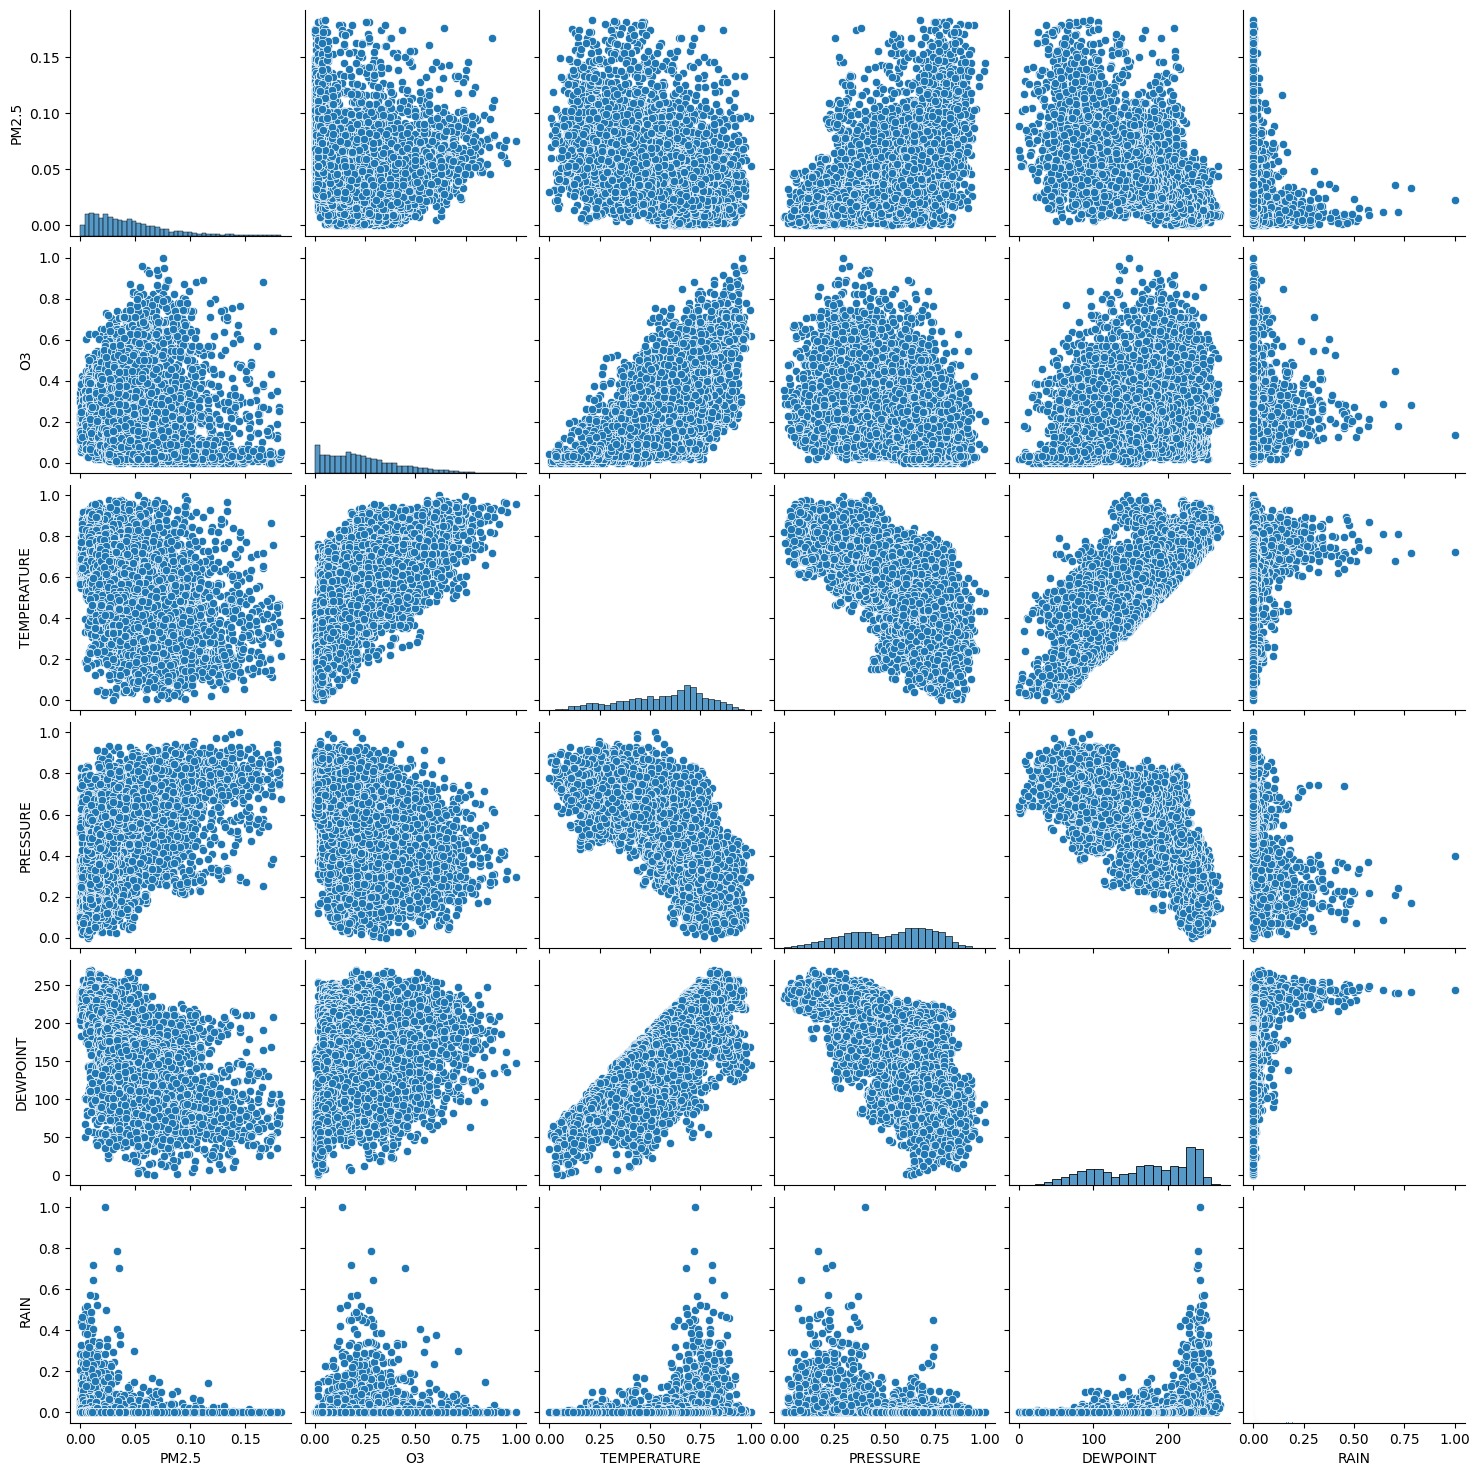

In [27]:
g = sns.pairplot(df)

<Axes: xlabel='PM2.5', ylabel='O3'>

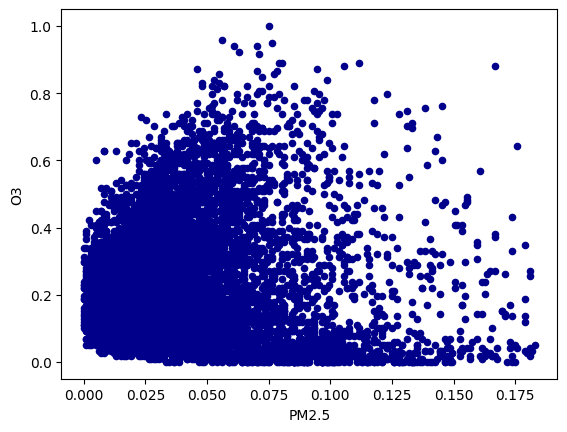

In [28]:
df.plot.scatter(x='PM2.5', y='O3', c='DarkBlue')

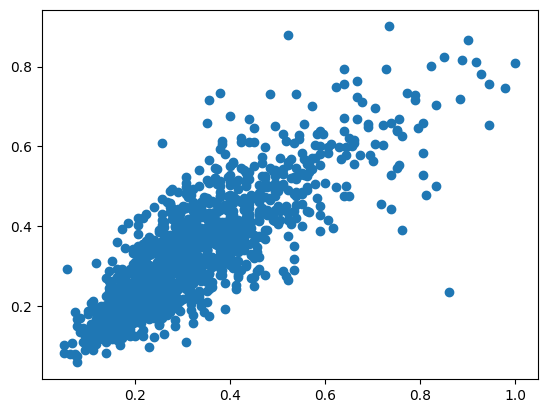

In [29]:
plt.scatter(y_test, y_pred)

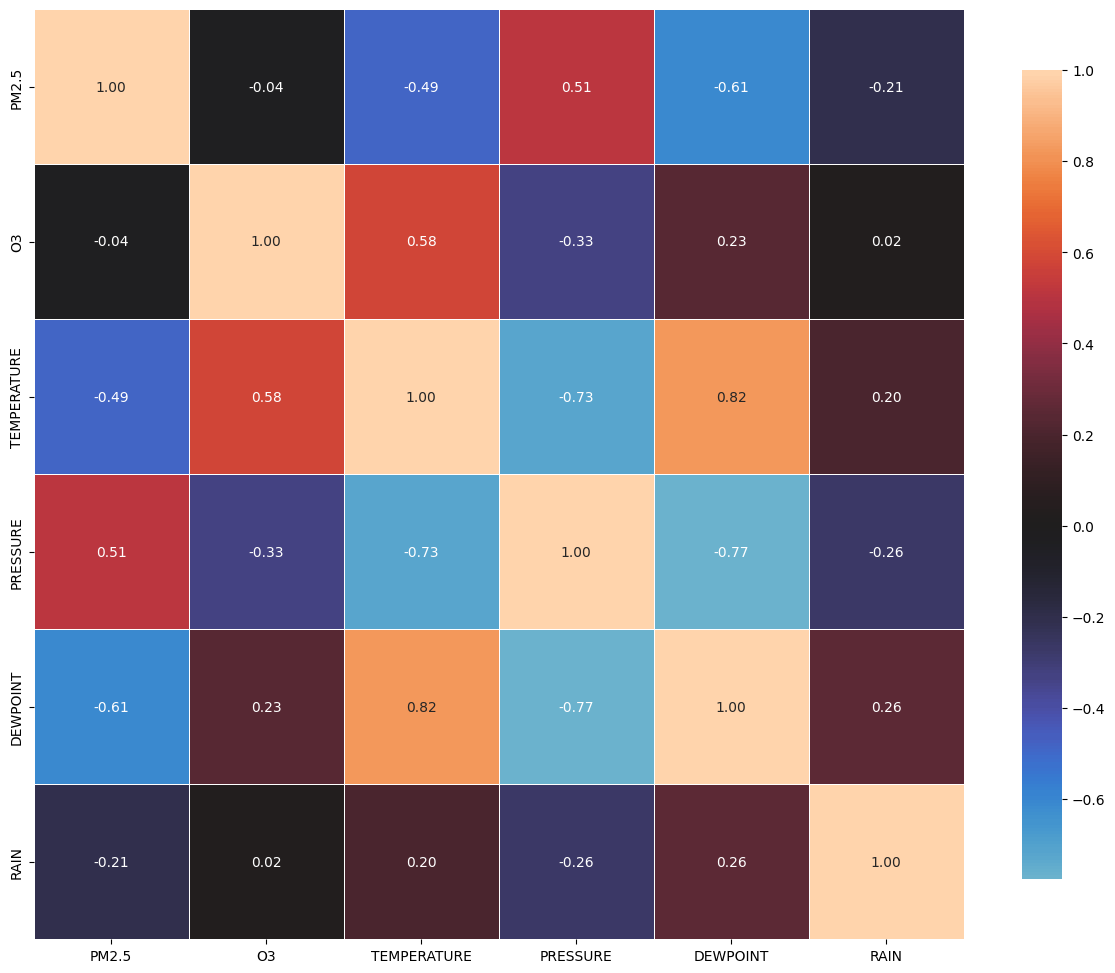

In [30]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

In [31]:
# Y_pred = model.predict(X_test)

# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test, Y_pred)

# rmse = np.sqrt(mse)
# rmse

In [40]:
# #Y_predicted = scaler.inverse_transform(Y_pred)
# print('y_predicted',Y_pred.shape)
# #print('X_train' ,X_train.shape)
# print('X_test' ,X_test.shape)
# print('scaled Values shape', scaled_dataset.shape)

y_predicted (1527, 1)
X_test (1527, 4, 6)
scaled Values shape (7637, 6)


In [47]:
# #Scaling back to the original scale
# # d = scaled_dataset[:8760,:]
# print('dummy',d.shape)
# print('Y_pred',Y_pred.shape)
# Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
# print('concat y_pred',Y_pred.shape)
# Y_tested = np.concatenate((y_test, d[:8760,1:]), axis = 1)
# print('concat Y_test', y_test.shape)

In [48]:
# Y_predicted = scaler.inverse_transform(Y_predicted)
# # Y_tested = scaler.inverse_transform(Y_tested)
# Y_predicted = Y_predicted[:,0:1]
# Y_tested = Y_tested[:,0:1]
# print('Y_tested', Y_tested.shape)
# print('Y_predicted', Y_predicted.shape)

In [49]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

0.029988809

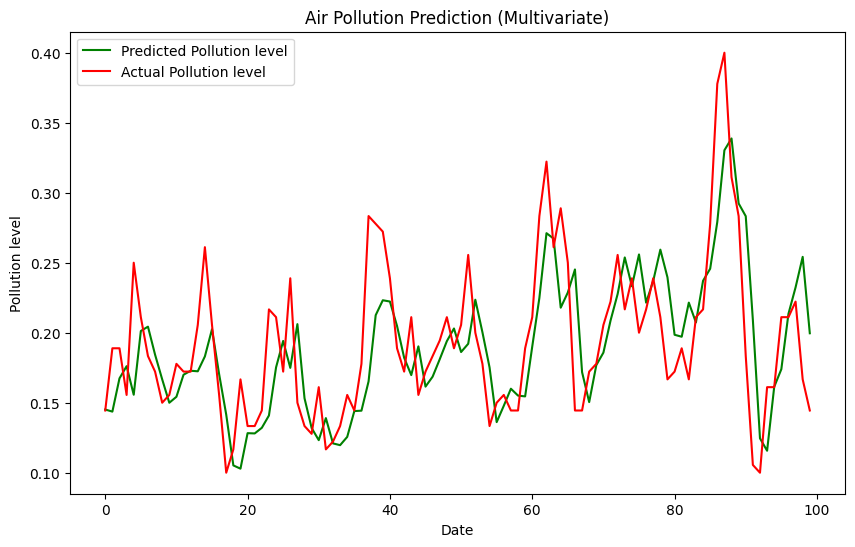

<Figure size 640x480 with 0 Axes>

In [32]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))  
plt.plot(y_pred[:100,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(y_test[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [51]:
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# mape = mean_absolute_percentage_error(y_test, Y_pred)
# print('MAPE', mape)


MAPE 24.39754605293274


In [52]:
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test, Y_pred)
# #print('Mean squared error', mse)
# print('RMSE' , np.sqrt(mse))
# print("Mean of Test data ", np.mean(y_test))

RMSE 0.029988809
Mean of Test data  0.05690391


In [53]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
# mae = mean_absolute_error(y_test, Y_pred)
# r2 = r2_score(Y_pred, Y_pred)

# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")
# print(f"R²: {r2}")

RMSE: 0.029988808557391167
MAE: 0.01320150587707758
R²: 1.0
